In [12]:
from google.colab import drive
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from scipy.signal import butter, filtfilt, resample
import matplotlib.pyplot as plt
import os
import re

In [13]:
np.random.seed(42)

In [14]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
model_path = '/content/drive/MyDrive/Data/model_ecg.h5'
print(f"Tải mô hình từ {model_path}...")
try:
    model = load_model(model_path)
except FileNotFoundError:
    print(f"Không tìm thấy file mô hình {model_path}. Vui lòng chạy code huấn luyện trước.")
    exit()

Tải mô hình từ /content/drive/MyDrive/Data/model_ecg.h5...


In [5]:
def bandpass_filter(data, lowcut=0.5, highcut=40.0, fs=200, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [16]:
def bandpass_filter(data, lowcut=0.5, highcut=40.0, fs=200, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [17]:
def standardize_segments(segments):
    standardized_segments = []
    for segment in segments:
        segment = (segment - np.mean(segment)) / np.std(segment)
        standardized_segments.append(segment)
    return np.array(standardized_segments)

In [18]:
print("Đang tải và tiền xử lý dữ liệu ECG thực tế...")
def load_ecg_from_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            values_match = re.search(r'Giá trị: ([\d,\s.-]+)', content)
            if not values_match:
                raise ValueError(f"Không tìm thấy trường 'Giá trị' trong file {file_path}")
            values = values_match.group(1).split(',')
            ecg_data = [float(val.strip()) for val in values if val.strip().replace('.', '').replace('-', '').isdigit()]

            qrs_match = re.search(r'Đỉnh QRS \(thời gian giây\): ([\d\s.,]+)', content)
            qrs_peaks = []
            if qrs_match:
                qrs_times = qrs_match.group(1).split(',')
                qrs_peaks = [float(t.strip()) for t in qrs_times if t.strip().replace('.', '').isdigit()]
                print(f"Đã đọc {len(ecg_data)} mẫu và {len(qrs_peaks)} đỉnh QRS từ {file_path}")
            else:
                print(f"Không tìm thấy trường 'Đỉnh QRS' trong {file_path}. Sử dụng cửa sổ trượt.")

            return np.array(ecg_data), qrs_peaks
    except FileNotFoundError:
        raise FileNotFoundError(f"Không tìm thấy file {file_path}")

Đang tải và tiền xử lý dữ liệu ECG thực tế...


In [19]:
def preprocess_real_world_data(ecg_data, qrs_peaks, sampling_rate=200, segment_length=200, file_path=''):
    ecg_data = bandpass_filter(ecg_data, fs=sampling_rate)

    target_samples = int(len(ecg_data) * 360 / sampling_rate)
    print(f"Tái lấy mẫu: {len(ecg_data)} mẫu -> {target_samples} mẫu")
    ecg_data = resample(ecg_data, target_samples)

    segments = []
    segment_qrs_indices = []
    if qrs_peaks:
        qrs_indices = [int(t * 360) for t in qrs_peaks if t * 360 < len(ecg_data)]
        print(f"Số đỉnh QRS hợp lệ: {len(qrs_indices)}")
        for idx in qrs_indices:
            start = max(0, idx - segment_length // 2)
            end = start + segment_length
            if end <= len(ecg_data):
                segment = ecg_data[start:end]
                segments.append(segment)
                segment_qrs_indices.append(idx)
    else:
        print("Không có đỉnh QRS, sử dụng cửa sổ trượt.")
        for i in range(0, len(ecg_data) - segment_length, segment_length // 2):
            segment = ecg_data[i:i + segment_length]
            if len(segment) == segment_length:
                segments.append(segment)
                segment_qrs_indices.append(i + segment_length // 2)

    if len(segments) == 0:
        print("Không tạo được đoạn nào từ dữ liệu. Kiểm tra độ dài tín hiệu hoặc đỉnh QRS.")
        return np.array([]), np.array([])

    segments = np.array(segments)
    segments = standardize_segments(segments)
    print(f"Tạo được {segments.shape[0]} đoạn từ dữ liệu")

    segments = segments.reshape(segments.shape[0], segments.shape[1], 1)

    try:
        predictions = model.predict(segments, verbose=0)
        predicted_labels = (predictions[:, 1] > 0.7).astype(int)
    except Exception as e:
        print(f"Lỗi khi dự đoán: {e}")
        return np.array([]), np.array([])

    abnormal_indices = [segment_qrs_indices[i] for i in range(len(predicted_labels)) if predicted_labels[i] == 1]

    plt.figure(figsize=(10, 4))
    time = np.arange(len(ecg_data)) / 360
    plt.plot(time[:3000], ecg_data[:3000], label='Tín hiệu ECG')
    for idx in abnormal_indices:
        if idx < 3000:
            plt.plot(idx / 360, ecg_data[idx], 'ro', label='Điểm bất thường' if idx == abnormal_indices[0] else '')
    plt.title(f"Tín hiệu ECG với các điểm bất thường (file: {os.path.basename(file_path)})")
    plt.xlabel('Thời gian (giây)')
    plt.ylabel('Biên độ')
    plt.legend()
    plt.show()

    return segments, predicted_labels

In [20]:
file_paths = [
    '/content/drive/MyDrive/Data/patient_000_20250623_155126.txt',
    '/content/drive/MyDrive/Data/patient_001_20250623_160031.txt'
]

Đã đọc 24000 mẫu và 173 đỉnh QRS từ /content/drive/MyDrive/Data/patient_000_20250623_155126.txt
Tái lấy mẫu: 24000 mẫu -> 43200 mẫu
Số đỉnh QRS hợp lệ: 173
Tạo được 173 đoạn từ dữ liệu


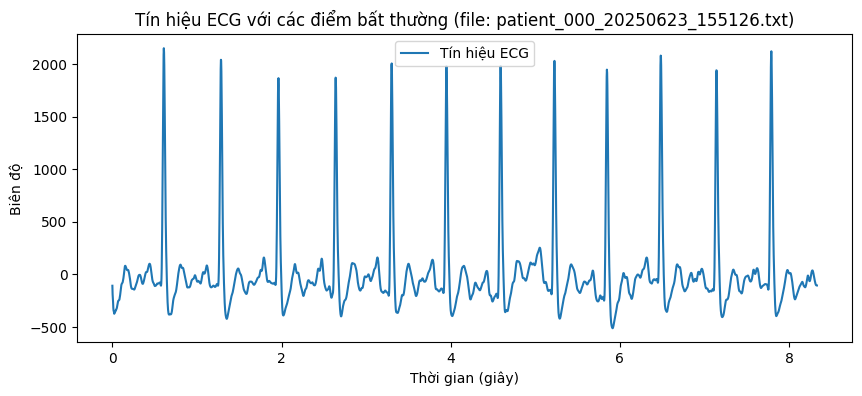


Kết quả cho bệnh nhân 000:
- Số đoạn đánh giá: 173
- Tỷ lệ đoạn bất thường: 0.00%
- Tỷ lệ đoạn bất thường thấp. ECG bình thường.
Đã đọc 24000 mẫu và 166 đỉnh QRS từ /content/drive/MyDrive/Data/patient_001_20250623_160031.txt
Tái lấy mẫu: 24000 mẫu -> 43200 mẫu
Số đỉnh QRS hợp lệ: 166
Tạo được 166 đoạn từ dữ liệu


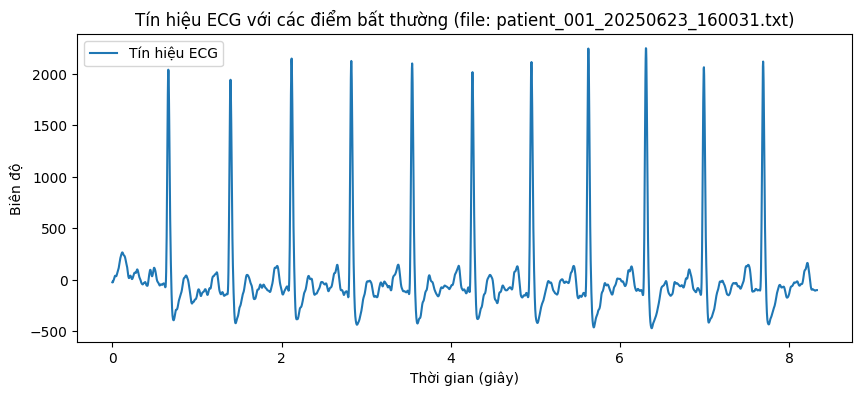


Kết quả cho bệnh nhân 001:
- Số đoạn đánh giá: 166
- Tỷ lệ đoạn bất thường: 0.00%
- Tỷ lệ đoạn bất thường thấp. ECG bình thường.


In [22]:
patient_results = {}

for file_path in file_paths:
    try:
        patient_id = os.path.basename(file_path).split('_')[1]
        ecg_data, qrs_peaks = load_ecg_from_file(file_path)
        if ecg_data.size == 0:
            print(f"Dữ liệu rỗng từ {file_path}. Bỏ qua file.")
            continue

        segments, predicted_labels = preprocess_real_world_data(ecg_data, qrs_peaks, sampling_rate=200, segment_length=200, file_path=file_path)
        if segments.size == 0 or len(predicted_labels) == 0:
            print(f"Không tạo được đoạn hoặc dự đoán từ {file_path}. Bỏ qua file.")
            continue

        abnormal_percentage = (np.sum(predicted_labels == 1) / len(predicted_labels)) * 100
        patient_results[patient_id] = {
            'num_segments': len(predicted_labels),
            'abnormal_percentage': abnormal_percentage,
            'predicted_labels': predicted_labels
        }

        print(f"\nKết quả cho bệnh nhân {patient_id}:")
        print(f"- Số đoạn đánh giá: {len(predicted_labels)}")
        print(f"- Tỷ lệ đoạn bất thường: {abnormal_percentage:.2f}%")
        if abnormal_percentage > 50:
            print("- Tỷ lệ đoạn bất thường cao. Đề nghị đánh giá lâm sàng vì nguy cơ đột quỵ tiềm tàng.")
        else:
            print("- Tỷ lệ đoạn bất thường thấp. ECG bình thường.")

    except Exception as e:
        print(f"Lỗi khi xử lý file {file_path}: {e}")
        continue

if not patient_results:
    print("Không có dữ liệu bệnh nhân nào được xử lý. Vui lòng kiểm tra file ECG thực tế.")
    exit()